In [13]:
!pip install  -q torch_snippets
from torch_snippets import *
from torchvision.datasets import MNIST
from torchvision import transforms
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [14]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5]),
    transforms.Lambda(lambda x:x.to(device))

])

In [15]:
trn_ds = MNIST('/content/',transform= img_transform, train= True, download=True)
val_ds = MNIST('/content/',transform=img_transform, train=False, download=True)

In [16]:
batch_size = 256

trn_dl = DataLoader(trn_ds , batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds , batch_size=batch_size, shuffle = False)


In [17]:
class AutoEncoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.latend_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128), nn.ReLU(True),
            nn.Linear(128, 64), nn.ReLU(True), 
            #nn.Linear(64, 12),  nn.ReLU(True), 
            nn.Linear(64, latent_dim))
        self.decoder = nn.Sequential(
            #nn.Linear(latent_dim, 12), nn.ReLU(True),
            nn.Linear(latent_dim, 64), nn.ReLU(True),
            nn.Linear(64, 128), nn.ReLU(True), 
            nn.Linear(128, 28 * 28), nn.Tanh())

    def forward(self, x):
        x = x.view(len(x), -1)
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(len(x), 1, 28, 28)
        return x

In [18]:
!pip install torch_summary
from torchsummary import summary
model = AutoEncoder(3).to(device)
summary(model, torch.zeros(2,1,28,28));  

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3]                   --
|    └─Linear: 2-1                       [-1, 128]                 100,480
|    └─ReLU: 2-2                         [-1, 128]                 --
|    └─Linear: 2-3                       [-1, 64]                  8,256
|    └─ReLU: 2-4                         [-1, 64]                  --
|    └─Linear: 2-5                       [-1, 3]                   195
├─Sequential: 1-2                        [-1, 784]                 --
|    └─Linear: 2-6                       [-1, 64]                  256
|    └─ReLU: 2-7                         [-1, 64]                  --
|    └─Linear: 2-8                       [-1, 128]                 8,320
|    └─ReLU: 2-9                         [-1, 128]                 --
|    └─Linear: 2-10                      [-1, 784]                 101,136
|    └─Tanh: 2-11                        [-1, 784]                 

In [19]:
def train_batch(input, model,criterion,optimizer):
    model.train()
    optimizer.zero_grad()
    output = model(input)
    loss = criterion(output,input)
    loss.backward()
    optimizer.step()
    return loss

@torch.no_grad()
def validate_batch(input,model,criterion):
    model.eval()
    output = model(input)
    loss = criterion(output,input)
    return loss

EPOCH: 1.000	trn_loss: 0.260	val_loss: 0.195	(15.37s - 61.48s remaining)
EPOCH: 2.000	trn_loss: 0.180	val_loss: 0.167	(30.53s - 45.80s remaining)
EPOCH: 3.000	trn_loss: 0.161	val_loss: 0.156	(45.38s - 30.26s remaining)
EPOCH: 4.000	trn_loss: 0.153	val_loss: 0.150	(60.54s - 15.14s remaining)
EPOCH: 5.000	trn_loss: 0.148	val_loss: 0.146	(75.90s - 0.00s remaining)


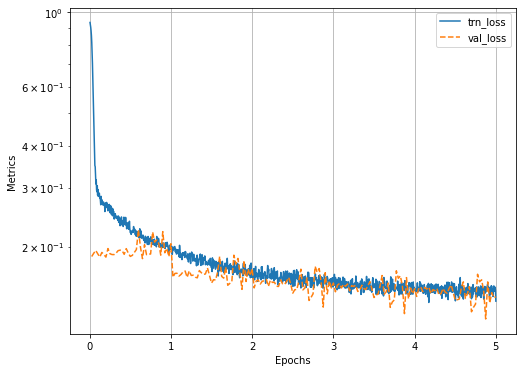

In [20]:
model = AutoEncoder(3).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.001, weight_decay= 1e-5)


num_epochs = 5
log = Report(num_epochs)

for epoch in range(num_epochs):
    N = len(trn_dl)
    for ix,(data, _) in enumerate(trn_dl):
        loss = train_batch(data,model,criterion,optimizer)
        log.record(pos=(epoch +(ix+1)/N), trn_loss=loss, end = '\r')

        
    N = len(val_dl)
    for ix, (data, _) in enumerate(val_dl):
        loss = validate_batch(data, model, criterion)
        log.record(pos=(epoch + (ix+1)/N), val_loss=loss, end='\r')
    log.report_avgs(epoch+1)
log.plot(log=True)

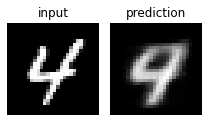

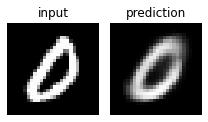

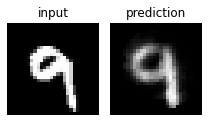

In [21]:
for _ in range(3):
    ix = np.random.randint(len(val_ds))
    im, _ = val_ds[ix]
    _im = model(im[None])[0]
    fig,ax = plt.subplots(1,2,figsize=(3,3))
    show(im[0], ax=ax[0], title='input')
    show(_im[0], ax=ax[1], title='prediction')
    plt.tight_layout()
    plt.show()

EPOCH: 1.000	trn_loss: 0.223	val_loss: 0.133	(15.02s - 60.10s remaining)
EPOCH: 2.000	trn_loss: 0.112	val_loss: 0.095	(29.88s - 44.82s remaining)
EPOCH: 3.000	trn_loss: 0.088	val_loss: 0.080	(44.95s - 29.97s remaining)
EPOCH: 4.000	trn_loss: 0.076	val_loss: 0.071	(60.38s - 15.10s remaining)
EPOCH: 5.000	trn_loss: 0.069	val_loss: 0.064	(75.91s - 0.00s remaining)


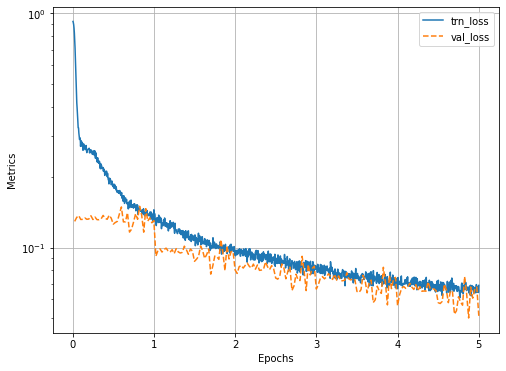

EPOCH: 1.000	trn_loss: 0.263	val_loss: 0.207	(14.89s - 59.55s remaining)
EPOCH: 2.000	trn_loss: 0.198	val_loss: 0.190	(29.94s - 44.91s remaining)
EPOCH: 3.000	trn_loss: 0.186	val_loss: 0.182	(45.07s - 30.05s remaining)
EPOCH: 4.000	trn_loss: 0.180	val_loss: 0.178	(60.55s - 15.14s remaining)
EPOCH: 5.000	trn_loss: 0.176	val_loss: 0.175	(76.09s - 0.00s remaining)


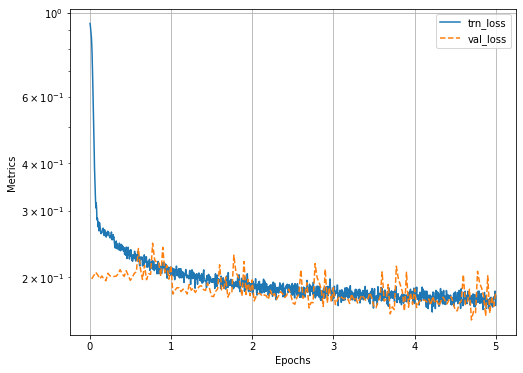

EPOCH: 1.000	trn_loss: 0.260	val_loss: 0.194	(14.99s - 59.95s remaining)
EPOCH: 2.000	trn_loss: 0.179	val_loss: 0.168	(30.06s - 45.09s remaining)
EPOCH: 3.000	trn_loss: 0.162	val_loss: 0.158	(45.05s - 30.03s remaining)
EPOCH: 4.000	trn_loss: 0.155	val_loss: 0.152	(60.47s - 15.12s remaining)
EPOCH: 5.000	trn_loss: 0.151	val_loss: 0.149	(75.94s - 0.00s remaining)


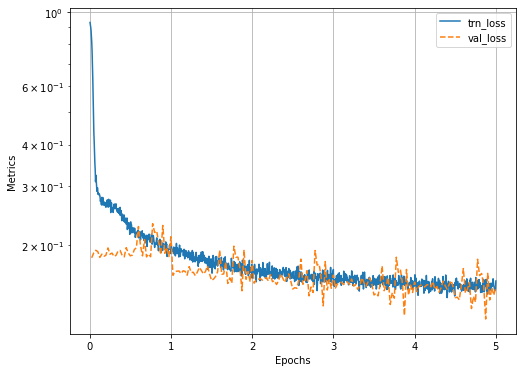

EPOCH: 1.000	trn_loss: 0.248	val_loss: 0.167	(15.12s - 60.46s remaining)
EPOCH: 2.000	trn_loss: 0.151	val_loss: 0.139	(30.19s - 45.29s remaining)
EPOCH: 3.000	trn_loss: 0.134	val_loss: 0.129	(45.36s - 30.24s remaining)
EPOCH: 4.000	trn_loss: 0.127	val_loss: 0.124	(60.78s - 15.20s remaining)
EPOCH: 5.000	trn_loss: 0.123	val_loss: 0.120	(76.33s - 0.00s remaining)


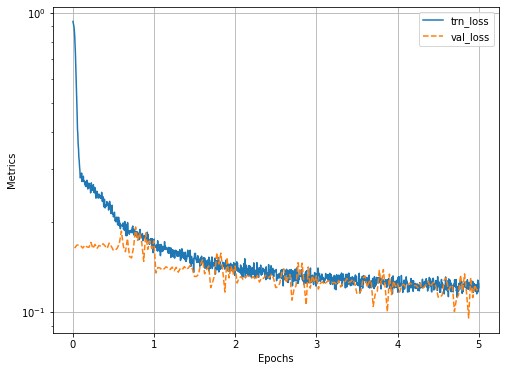

EPOCH: 1.000	trn_loss: 0.250	val_loss: 0.158	(14.97s - 59.86s remaining)
EPOCH: 2.000	trn_loss: 0.135	val_loss: 0.119	(30.00s - 45.00s remaining)
EPOCH: 3.000	trn_loss: 0.113	val_loss: 0.106	(45.06s - 30.04s remaining)
EPOCH: 4.000	trn_loss: 0.103	val_loss: 0.098	(60.52s - 15.13s remaining)
EPOCH: 5.000	trn_loss: 0.097	val_loss: 0.094	(75.93s - 0.00s remaining)


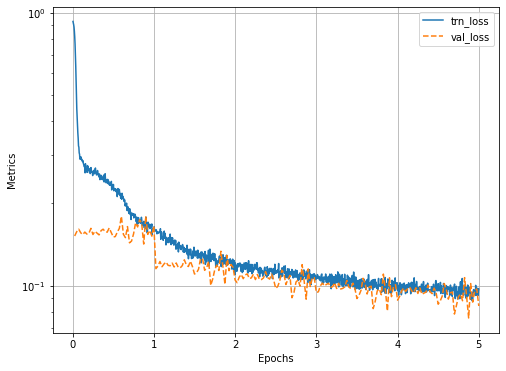

In [22]:
def train_aec(latent_dim):
    model = AutoEncoder(latent_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

    num_epochs = 5
    log = Report(num_epochs)

    for epoch in range(num_epochs):
        N = len(trn_dl)
        for ix, (data, _) in enumerate(trn_dl):
            loss = train_batch(data, model, criterion, optimizer)
            log.record(pos=(epoch + (ix+1)/N), trn_loss=loss, end='\r')

        N = len(val_dl)
        for ix, (data, _) in enumerate(val_dl):
            loss = validate_batch(data, model, criterion)
            log.record(pos=(epoch + (ix+1)/N), val_loss=loss, end='\r')
        log.report_avgs(epoch+1)
    log.plot(log=True)
    return model

aecs = [train_aec(dim) for dim in [50, 2, 3, 5, 10]]

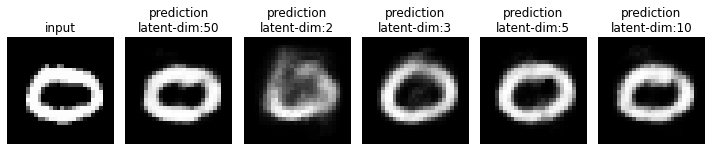

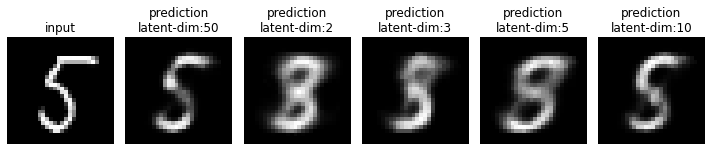

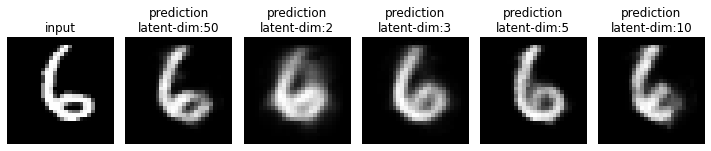

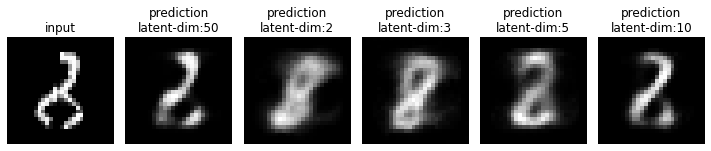

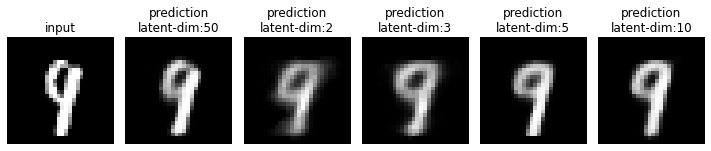

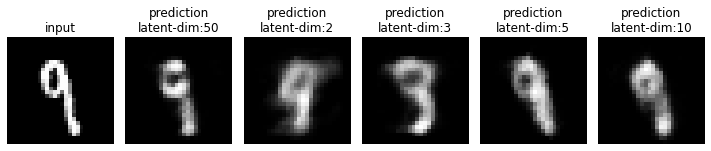

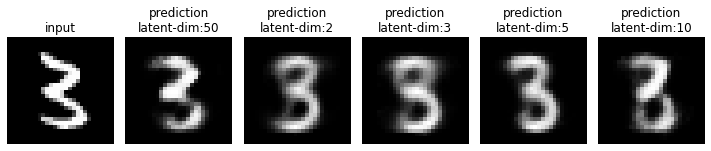

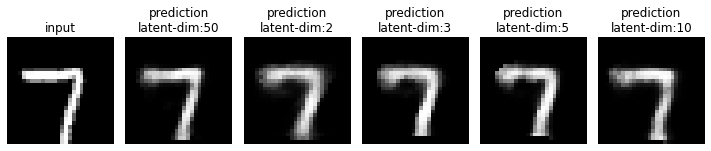

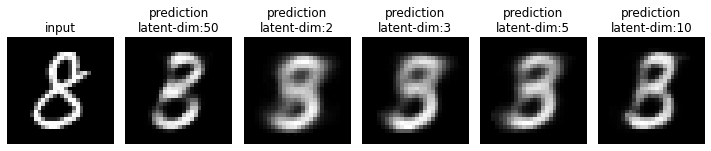

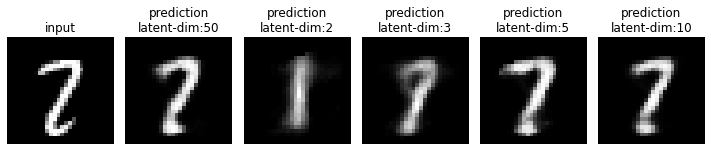

In [23]:
for _ in range(10):
    ix = np.random.randint(len(val_ds))
    im, _ = val_ds[ix]
    fig, ax = plt.subplots(1, len(aecs)+1, figsize=(10,4))
    ax = iter(ax.flat)
    show(im[0], ax=next(ax), title='input')
    for model in aecs:
        _im = model(im[None])[0]
        show(_im[0], ax=next(ax), title=f'prediction\nlatent-dim:{model.latend_dim}')
    plt.tight_layout()
    plt.show()